In [ ]:
import pandas as pd
import numpy as np
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign'

In [6]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [8]:
len(np.unique(y_train))

43

In [9]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [10]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [11]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
    Flatten(),
    Dense(num_classes, activation='softmax'),              
])

#model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 4s 3ms/step - loss: 8.7138 - accuracy: 0.7765


In [15]:
def get_cnn_v1(input_shape, num_classes): 
  return Sequential([
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
      Flatten(),
      Dense(num_classes, activation='softmax'),              
  ])
   
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
  )
      
  return model

In [16]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 10ms/step - loss: 30.1981 - accuracy: 0.7501 - val_loss: 0.2196 - val_accuracy: 0.9522
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 0.2159 - accuracy: 0.9510 - val_loss: 0.1523 - val_accuracy: 0.9657
Epoch 3/5
272/272 [==============================] - 2s 8ms/step - loss: 0.1633 - accuracy: 0.9627 - val_loss: 0.0851 - val_accuracy: 0.9792
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1210 - accuracy: 0.9731 - val_loss: 0.0809 - val_accuracy: 0.9822
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1112 - accuracy: 0.9750 - val_loss: 0.0567 - val_accuracy: 0.9867


In [ ]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [32]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [34]:
predict(model_trained, X_test, y_test)

0.83718820861678

In [35]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [39]:
def get_cnn_v2(input_shape, num_classes): 
  return Sequential([
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Flatten(),

      Dense(1024, activation='relu'), 
      Dropout(0.3),

      Dense(num_classes, activation='softmax'),              
  ])

train_and_predict( get_cnn_v2(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 3s 10ms/step - loss: 6.8173 - accuracy: 0.1969 - val_loss: 1.7937 - val_accuracy: 0.4794
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 1.6104 - accuracy: 0.5242 - val_loss: 0.7738 - val_accuracy: 0.7999
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.8713 - accuracy: 0.7383 - val_loss: 0.2968 - val_accuracy: 0.9344
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.5026 - accuracy: 0.8461 - val_loss: 0.1629 - val_accuracy: 0.9673
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.3736 - accuracy: 0.8877 - val_loss: 0.0955 - val_accuracy: 0.9833


0.909750566893424

In [51]:
def get_cnn_v3(input_shape, num_classes): 
  return Sequential([
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), 
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Flatten(),

      Dense(1024, activation='relu'), 
      Dropout(0.3),

      Dense(num_classes, activation='softmax'),              
  ])

train_and_predict( get_cnn_v3(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.0998 - accuracy: 0.5736 - val_loss: 0.4016 - val_accuracy: 0.9227
Epoch 2/5
272/272 [==============================] - 3s 13ms/step - loss: 0.4478 - accuracy: 0.8681 - val_loss: 0.1021 - val_accuracy: 0.9722
Epoch 3/5
272/272 [==============================] - 3s 13ms/step - loss: 0.2466 - accuracy: 0.9267 - val_loss: 0.0484 - val_accuracy: 0.9868
Epoch 4/5
272/272 [==============================] - 3s 13ms/step - loss: 0.1680 - accuracy: 0.9496 - val_loss: 0.0257 - val_accuracy: 0.9936
Epoch 5/5
272/272 [==============================] - 3s 13ms/step - loss: 0.1311 - accuracy: 0.9598 - val_loss: 0.0225 - val_accuracy: 0.9945


0.9473922902494331

In [52]:
def get_cnn_v4(input_shape, num_classes): 
  return Sequential([
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'), 
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Flatten(),

      Dense(1024, activation='relu'), 
      Dropout(0.3),

      Dense(num_classes, activation='softmax'),              
  ])

train_and_predict( get_cnn_v4(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 2.5271 - accuracy: 0.3200 - val_loss: 0.8755 - val_accuracy: 0.7501
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.7981 - accuracy: 0.7515 - val_loss: 0.2131 - val_accuracy: 0.9243
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.3953 - accuracy: 0.8782 - val_loss: 0.0807 - val_accuracy: 0.9800
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2546 - accuracy: 0.9220 - val_loss: 0.0423 - val_accuracy: 0.9890
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1804 - accuracy: 0.9445 - val_loss: 0.0397 - val_accuracy: 0.9892


0.9657596371882086

In [54]:
def get_cnn_v5(input_shape, num_classes): 
  return Sequential([
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
      Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'), 
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      MaxPool2D(),
      Dropout(0.3),

      Flatten(),

      Dense(1024, activation='relu'), 
      Dropout(0.3),

      Dense(1024, activation='relu'), 
      Dropout(0.3),

      Dense(num_classes, activation='softmax'),              
  ])

train_and_predict( get_cnn_v5(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 2.5448 - accuracy: 0.2932 - val_loss: 1.0143 - val_accuracy: 0.6664
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.8236 - accuracy: 0.7390 - val_loss: 0.2246 - val_accuracy: 0.9242
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3545 - accuracy: 0.8921 - val_loss: 0.0871 - val_accuracy: 0.9749
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.2226 - accuracy: 0.9321 - val_loss: 0.0834 - val_accuracy: 0.9761
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1756 - accuracy: 0.9494 - val_loss: 0.0340 - val_accuracy: 0.9912


0.9718820861678005

In [55]:
X_train[0].shape

(32, 32, 3)

In [60]:
color.rgb2gray(X_train[0]).shape

(32, 32)

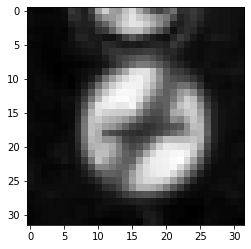

In [59]:
plt.imshow( color.rgb2gray( X_train[0] ), cmap=plt.get_cmap('gray') )

In [69]:
X_train_gray = color.rgb2gray( X_train ).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray( X_test ).reshape(-1, 32, 32, 1)

In [72]:
model = get_cnn_v5((32, 32, 1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 2.6177 - accuracy: 0.2669 - val_loss: 0.6898 - val_accuracy: 0.7848
Epoch 2/5
272/272 [==============================] - 4s 16ms/step - loss: 0.5356 - accuracy: 0.8280 - val_loss: 0.1351 - val_accuracy: 0.9649
Epoch 3/5
272/272 [==============================] - 4s 16ms/step - loss: 0.2517 - accuracy: 0.9197 - val_loss: 0.0735 - val_accuracy: 0.9774
Epoch 4/5
272/272 [==============================] - 4s 16ms/step - loss: 0.1746 - accuracy: 0.9462 - val_loss: 0.0399 - val_accuracy: 0.9886
Epoch 5/5
272/272 [==============================] - 4s 16ms/step - loss: 0.1257 - accuracy: 0.9611 - val_loss: 0.0274 - val_accuracy: 0.9923


0.9689342403628118